# **Project Overview** 
As the capabilities of Large Language Models (LLMs) continue to grow, evaluating their performance has become more important than ever, especially in the face of the biases that can be embedded in them [1]. Human evaluation of LLMs is crucial, yet poses a variety of challenges due to the inherently subjective nature of human assessments. What one user considers to be a “good” response may not be perceived as such by another user, leading to inconsistent feedback of LLM performance [2]. Additionally, there is currently no “standard” methodology or consensus on best practices for the human evaluation of LLMs, making it challenging to compare different research results studying their performance [3]. Ultimately, these factors make it difficult to integrate stable human evaluations into the development and refinement process of LLMs. 


In an effort to address this gap, a group of researchers created the “Chatbot Arena,” which is “an open platform for evaluating LLMs based on human preferences” [4]. Much like using a traditional LLM, users can pose questions (hereinafter referred to as “prompts”) and receive answers (hereinafter referred to as “responses”) from an LLM. However, unlike traditional LLMs, users receive two different responses from two different models presented side-by-side. The user is asked to select the response they prefer or select a tie. The model is anonymous, meaning that the user does not know which model produced the responses until after they have selected the winner. This eliminates any potential biases that might arise from name recognition or previous experiences with specific models.


Using a select dataset of over 17,000 conversations from the Chatbot Arena, we attempt to investigate and understand user preferences in various LLM interactions. Based on the user’s prompt, the two model responses, the selected “winner,” topic modeling data, and the prompt’s hardness scores, we attempt to complete two primary tasks. The first task (Task A) is the prediction of the winning model between Model A and Model B. The second task (Task B) is the prediction of the hardness score of the user’s prompt. 


The research questions for this project are as follows:
* **RQ1:** *Can we use logistic regression to predict if “Model A” or “Model B” will be selected as the winner by a random user in a Chatbot Arena “battle”?*
* **RQ2:** *Can we use linear regression to predict the hardness score of a given prompt?*

***In this notebook, you will the find logistic and linear regression models that have been feature engineered to predict model performance in battle and prompt difficulty in response to RQ1 and RQ2. It is the second of two notebooks used for this project.***

# **1. Import libraries**

In [7]:
# IMPORTS
from collections import defaultdict  # https://docs.python.org/3/library/collections.html Return a new dictionary-like object.
import json, math, gdown
import numpy as np
import pandas as pd
import plotly.express as px
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import textstat

sns.set_theme(style="whitegrid")
pd.options.display.float_format = '{:.2f}'.format

In [9]:
# Embeddings
import requests
import numpy as np
from io import BytesIO

# URL of the raw .npy file
file_url = "https://github.com/dychenster/nlp-chatarena/blob/main/chatbot-arena-prompts-embeddings.npy?raw=true"

# Use requests to get the file content
response = requests.get(file_url)

# Make sure the request was successful
if response.status_code == 200:
    # Load the content into a numpy array
    content = BytesIO(response.content)
    embeddings = np.load(content)
    print("Embeddings loaded successfully into Colab.")
else:
    print(f"Failed to load the file. Status code: {response.status_code}")

Embeddings loaded successfully into Colab.


In [10]:
# Load in Chatbot Arena Conversations Dataset

# Provide the raw URL of the JSON file
url_conversations = "https://raw.githubusercontent.com/dychenster/nlp-chatarena/main/chatbot-arena-conversations.jsonl.gz"

# Read the JSON file into a DataFrame
conversations = pd.read_json(url_conversations, lines=True)

# Display the first row of the data
conversations.head(1)

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...


In [11]:
# Load in Related Topic & Hardness Dataset

# Provide the raw URL of the JSON file
url_scores = "https://raw.githubusercontent.com/dychenster/nlp-chatarena/main/chatbot-arena-gpt3-scores.jsonl.gz"

# Read the JSON file into a DataFrame
topic_and_hardness = pd.read_json(url_scores, lines=True)

# Display the first row of the data
topic_and_hardness.head(1)
topic_and_hardness.shape

(25322, 12)

# **2. Data Cleaning & Preparing for Modeling**

## 2a. ChatArena Data

In [12]:
# Create a prompt column
conversations["prompt"] = conversations["conversation_a"].str[0].str["content"]
conversations["prompt"].head(1)

0    What is the difference between OpenCL and CUDA?
Name: prompt, dtype: object

In [13]:
# Create a response columns
conversations["model_a_response"] = conversations["conversation_a"].str[1].str["content"]
conversations["model_b_response"] = conversations["conversation_b"].str[1].str["content"]

# Create prompt and response length columns
conversations["prompt_length"] = conversations["prompt"].str.len()
conversations["response_a_length"] = conversations["model_a_response"].str.len()
conversations["response_b_length"] = conversations["model_b_response"].str.len()

# Remove rows with tie (bothbad) and tie as winners
conversations = conversations.loc[~conversations["winner"].isin(["tie (bothbad)", "tie"])]

# Remove conversation_a and conversation_b columns
conversations.drop(columns=["conversation_a", "conversation_b"], inplace=True)
conversations.head(1)

,question_id,model_a,model_b,winner,judge,prompt,model_a_response,model_b_response,prompt_length,response_a_length,response_b_length
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,What is the difference between OpenCL and CUDA?,OpenCL and CUDA are two different programming ...,OpenCL and CUDA are both programming languages...,47,892,1905


In [14]:
# Reorganize conversations dataframe columns

conversations["winner_name"] = np.where(conversations["winner"] == "model_a", conversations["model_a"], conversations["model_b"])
col = conversations.pop("winner_name")
conversations.insert(4, "winner_name", col)

conversations.head(1)

,question_id,model_a,model_b,winner,winner_name,judge,prompt,model_a_response,model_b_response,prompt_length,response_a_length,response_b_length
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,koala-13b,arena_user_973,What is the difference between OpenCL and CUDA?,OpenCL and CUDA are two different programming ...,OpenCL and CUDA are both programming languages...,47,892,1905


In [15]:
# Calculate win rate of each model

conversations["winner_name"].value_counts()

win_rates = conversations["winner_name"].value_counts() / (conversations["model_a"].value_counts() + conversations["model_b"].value_counts())
win_rates.sort_values(ascending=False)

gpt-4                     0.85
claude-v1                 0.80
claude-instant-v1         0.76
gpt-3.5-turbo             0.71
vicuna-13b                0.62
guanaco-33b               0.60
palm-2                    0.59
wizardlm-13b              0.54
koala-13b                 0.51
vicuna-7b                 0.45
mpt-7b-chat               0.35
alpaca-13b                0.35
oasst-pythia-12b          0.35
gpt4all-13b-snoozy        0.34
RWKV-4-Raven-14B          0.34
chatglm-6b                0.30
fastchat-t5-3b            0.30
stablelm-tuned-alpha-7b   0.26
dolly-v2-12b              0.23
llama-13b                 0.20
Name: count, dtype: float64

In [16]:
# Look at how often the longer responses were selected as the "winner"

conversations["length_difference"] = conversations["response_a_length"] - conversations["response_b_length"]
conversations["longer_response"] = conversations.apply(lambda row: "model_a" if row["length_difference"] > 0 else "model_b", axis=1)

longer_response_chosen_count = (conversations['winner'] == conversations['longer_response']).sum()

display("The proportion of times the longer response was chosen as the 'winner': " + str(longer_response_chosen_count/len(conversations)))

"The proportion of times the longer response was chosen as the 'winner': 0.6331321260898726"

## 2b. Topic & Hardness Data

In [17]:
# Remove null values from scores values
topic_and_hardness = topic_and_hardness.dropna(subset=['score_value_1', 'score_value_2', 'score_value_3'])
print(topic_and_hardness[['score_value_1', 'score_value_2', 'score_value_3']].isna().sum())

# Change all score values to be numeric
topic_and_hardness.loc[:,'score_value_1'] = pd.to_numeric(topic_and_hardness['score_value_1'], errors='coerce')
topic_and_hardness.loc[:,'score_value_2'] = pd.to_numeric(topic_and_hardness['score_value_2'], errors='coerce')
topic_and_hardness.loc[:,'score_value_3'] = pd.to_numeric(topic_and_hardness['score_value_3'], errors='coerce')

# Drop any resulting null values
topic_and_hardness= topic_and_hardness.dropna(subset=['score_value_1', 'score_value_2', 'score_value_3'])

# Change all score values to be integers
topic_and_hardness['score_value_1'] = topic_and_hardness['score_value_1'].astype(np.int64)
topic_and_hardness['score_value_2'] = topic_and_hardness['score_value_2'].astype(np.int64)
topic_and_hardness['score_value_3'] = topic_and_hardness['score_value_3'].astype(np.int64)

# Verify all score values are integers
topic_and_hardness.dtypes

score_value_1    0
score_value_2    0
score_value_3    0
dtype: int64


question_id                         object
prompt                              object
openai_scores_raw_choices_nested    object
topic_modeling_1                    object
score_reason_1                      object
score_value_1                        int64
topic_modeling_2                    object
score_reason_2                      object
score_value_2                        int64
topic_modeling_3                    object
score_reason_3                      object
score_value_3                        int64
dtype: object

## 2c. Merged Data

In [18]:
# Merge conversations and topic/hardness dataframes
merged_df = conversations.merge(topic_and_hardness, on="question_id")
merged_df.head(1)

,question_id,model_a,model_b,winner,winner_name,judge,prompt_x,model_a_response,model_b_response,prompt_length,...,openai_scores_raw_choices_nested,topic_modeling_1,score_reason_1,score_value_1,topic_modeling_2,score_reason_2,score_value_2,topic_modeling_3,score_reason_3,score_value_3
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,koala-13b,arena_user_973,What is the difference between OpenCL and CUDA?,OpenCL and CUDA are two different programming ...,OpenCL and CUDA are both programming languages...,47,...,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",Technical Comparison,This prompt requires the AI to accurately comp...,9,Software Comparison,This prompt assesses the AI's factual accuracy...,8,"Comparison, Technology",This prompt requires the AI to demonstrate kno...,9


In [19]:
# Remove certain columns
merged_df.drop(columns=["openai_scores_raw_choices_nested", "topic_modeling_1", "topic_modeling_2", "topic_modeling_3", "score_reason_1", "score_reason_2", "score_reason_3", "prompt_y"], inplace=True)
merged_df.head(1)

,question_id,model_a,model_b,winner,winner_name,judge,prompt_x,model_a_response,model_b_response,prompt_length,response_a_length,response_b_length,length_difference,longer_response,score_value_1,score_value_2,score_value_3
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,koala-13b,arena_user_973,What is the difference between OpenCL and CUDA?,OpenCL and CUDA are two different programming ...,OpenCL and CUDA are both programming languages...,47,892,1905,-1013,model_b,9,8,9


In [20]:
# Rename columns
merged_df.rename(columns={"prompt_x":"prompt"}, inplace=True)
merged_df.head(1)

,question_id,model_a,model_b,winner,winner_name,judge,prompt,model_a_response,model_b_response,prompt_length,response_a_length,response_b_length,length_difference,longer_response,score_value_1,score_value_2,score_value_3
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,koala-13b,arena_user_973,What is the difference between OpenCL and CUDA?,OpenCL and CUDA are two different programming ...,OpenCL and CUDA are both programming languages...,47,892,1905,-1013,model_b,9,8,9


In [21]:
# Add total (average) score for each battle
merged_df["average_score"] = (merged_df["score_value_1"] + merged_df["score_value_2"] + merged_df["score_value_3"])/ 3

# Average hardness score per model (in winning rows)
average_hardness_per_model = merged_df.groupby("winner_name")["average_score"].mean().sort_values(ascending=False)
average_hardness_per_model

winner_name
claude-instant-v1         7.26
gpt-4                     7.25
gpt-3.5-turbo             7.22
vicuna-7b                 7.21
claude-v1                 7.20
palm-2                    7.14
fastchat-t5-3b            7.12
wizardlm-13b              7.10
oasst-pythia-12b          7.07
vicuna-13b                7.07
koala-13b                 7.06
RWKV-4-Raven-14B          7.05
stablelm-tuned-alpha-7b   7.05
mpt-7b-chat               7.00
guanaco-33b               6.97
gpt4all-13b-snoozy        6.93
dolly-v2-12b              6.91
alpaca-13b                6.84
chatglm-6b                6.81
llama-13b                 6.67
Name: average_score, dtype: float64

In [22]:
# Compute total hardness of each prompt
merged_df["total_hardness"] = merged_df["score_value_1"] + merged_df["score_value_2"] + merged_df["score_value_3"]
merged_df.head(1)

,question_id,model_a,model_b,winner,winner_name,judge,prompt,model_a_response,model_b_response,prompt_length,response_a_length,response_b_length,length_difference,longer_response,score_value_1,score_value_2,score_value_3,average_score,total_hardness
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,koala-13b,arena_user_973,What is the difference between OpenCL and CUDA?,OpenCL and CUDA are two different programming ...,OpenCL and CUDA are both programming languages...,47,892,1905,-1013,model_b,9,8,9,8.67,26


In [23]:
# Use texstat library - Flesch Reading Ease
merged_df["model_a_complexity"] = (merged_df["model_a_response"]).apply(textstat.flesch_reading_ease)
merged_df["model_b_complexity"] = (merged_df["model_b_response"]).apply(textstat.flesch_reading_ease)
merged_df["prompt_complexity"] = (merged_df["prompt"]).apply(textstat.flesch_reading_ease)

#90-100	Very Easy
#80-89	Easy
#70-79	Fairly Easy
#60-69	Standard
#50-59	Fairly Difficult
#30-49	Difficult
#0-29	Very Confusing

In [24]:
# Readability consensus (grade level)
merged_df["model_a_grade"] = merged_df["model_a_response"].apply(lambda x: textstat.text_standard(x, float_output=True))
merged_df["model_b_grade"] = merged_df["model_b_response"].apply(lambda x: textstat.text_standard(x, float_output=True))
merged_df["prompt_grade"] = merged_df["prompt"].apply(lambda x: textstat.text_standard(x, float_output=True))

In [25]:
# Reading time
merged_df["model_a_time"] = merged_df["model_a_response"].apply(lambda x: textstat.reading_time(x, ms_per_char=14.69))
merged_df["model_b_time"] = merged_df["model_b_response"].apply(lambda x: textstat.reading_time(x, ms_per_char=14.69))
merged_df["prompt_time"] = merged_df["prompt"].apply(lambda x: textstat.reading_time(x, ms_per_char=14.69))

In [26]:
merged_df.shape

(17045, 28)

In [30]:
#Test

# **3. Task A** 
# Given a prompt, can we predict which model’s response will win the user vote?*

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

## 3a. Logistic Regression Model

In [23]:
# One-hot encode the model names

# Create an array with all the model names
models_combined = pd.concat([merged_df["model_a"], merged_df["model_b"]]).unique()

# Initialize the columns to zero
for model in models_combined:
    merged_df[model] = 0

# Use logical OR to combine the one-hot encoding for both model_a and model_b
for model in models_combined:
    merged_df[model] = ((merged_df["model_a"] == model) | (merged_df["model_b"] == model)).astype(int)

In [24]:
# Add a new feature for the win rate of model_a
merged_df['model_a_win_rate'] = merged_df['model_a'].map(win_rates)

# Add a new feature for the win rate of model_b
merged_df['model_b_win_rate'] = merged_df['model_b'].map(win_rates)

In [25]:
# merged_df["winner_binary"] = (merged_df['winner'] == 'model_b')

# Features for model
features = ["prompt_length", "prompt_complexity", "prompt_grade", "prompt_time", "model_a_win_rate", "model_b_win_rate",
            'chatglm-6b', 'koala-13b', 'vicuna-13b', 'stablelm-tuned-alpha-7b','oasst-pythia-12b', 'dolly-v2-12b', 'alpaca-13b', 'llama-13b', 'fastchat-t5-3b', 'gpt-3.5-turbo', \
            'gpt-4', 'claude-v1', 'RWKV-4-Raven-14B', 'mpt-7b-chat', 'palm-2', 'claude-instant-v1', 'vicuna-7b', 'wizardlm-13b', 'gpt4all-13b-snoozy', 'guanaco-33b']


X = merged_df[features]
y = merged_df["winner"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.20, random_state=42)

# Create a logistic regression model
model_task_a = LogisticRegression(max_iter=2000)

# Train the model
model_task_a.fit(X_train, y_train)

# Predict the test set
y_pred_encoded = model_task_a.predict(X_test)

# Decode the predictions back to 'model_a' and 'model_b'
y_pred = le.inverse_transform(y_pred_encoded)

# Calculate the accuracy, precision, recall
accuracy = accuracy_score(y_test, y_pred_encoded)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred_encoded, target_names=le.classes_))

Accuracy: 0.750073335288941
              precision    recall  f1-score   support

     model_a       0.73      0.77      0.75      1665
     model_b       0.77      0.73      0.75      1744

    accuracy                           0.75      3409
   macro avg       0.75      0.75      0.75      3409
weighted avg       0.75      0.75      0.75      3409



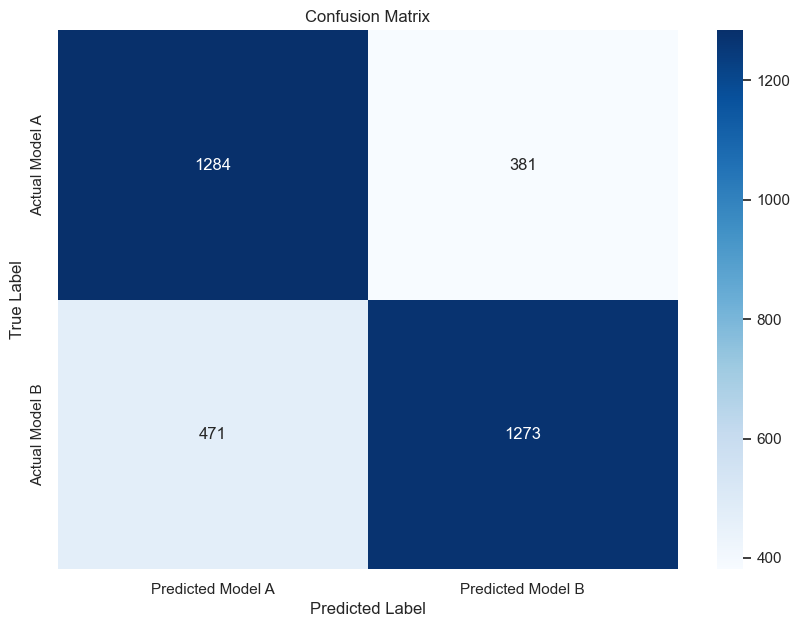

In [28]:
# Generating the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_encoded)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Model A', 'Predicted Model B'],
            yticklabels=['Actual Model A', 'Actual Model B'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [30]:
# K-Fold Cross-Validation

from sklearn.model_selection import cross_val_score

X = merged_df[features]
y = merged_df["winner"]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(model_task_a, X, y, cv=kf, scoring="accuracy")

# Print the accuracy for each fold
print(f'Accuracies for each fold: {cv_scores}')

# Print the mean of the cross-validation accuracy
print(f'Mean CV Accuracy: {cv_scores.mean()}')

Accuracies for each fold: [0.75007334 0.75359343 0.74655324 0.73364623 0.74185978]
Mean CV Accuracy: 0.7451452038721034


# **4. Task B**
# Can we guess the hardness score of a given prompt?*

In [29]:
# IMPORTS

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Text Libraries
from textstat import flesch_kincaid_grade, gunning_fog
import textstat
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mayaschoucair/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [32]:
embeddings.shape[1]

256

In [33]:
embeddings_df = pd.DataFrame(embeddings, columns=[f'e_{i}' for i in range(256)])
embeddings_df

,e_0,e_1,e_2,e_3,e_4,e_5,e_6,e_7,e_8,e_9,...,e_246,e_247,e_248,e_249,e_250,e_251,e_252,e_253,e_254,e_255
0,-0.12,-0.12,0.04,0.02,0.09,-0.03,0.00,-0.08,0.09,-0.00,...,-0.02,-0.11,0.03,0.01,0.02,0.06,-0.16,-0.02,-0.04,-0.04
1,0.01,0.03,-0.09,0.04,-0.08,-0.05,-0.05,-0.03,-0.08,0.04,...,-0.01,-0.03,-0.01,0.03,-0.02,-0.08,0.06,0.09,-0.05,0.00
2,-0.04,-0.11,-0.02,-0.04,0.04,-0.05,-0.01,0.03,0.03,0.02,...,-0.08,0.06,-0.06,0.06,0.03,0.06,-0.04,-0.14,0.00,0.00
3,-0.05,-0.00,0.09,0.03,-0.04,-0.10,-0.02,0.01,-0.06,0.05,...,-0.07,-0.10,0.15,0.03,-0.01,0.06,0.03,-0.03,0.05,-0.06
4,-0.04,0.05,0.06,0.05,0.05,-0.02,0.06,0.05,-0.07,-0.02,...,0.01,-0.04,-0.01,0.07,0.07,-0.04,-0.08,-0.05,0.01,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25317,-0.03,-0.03,-0.02,-0.09,-0.09,-0.02,0.08,-0.01,0.05,-0.03,...,-0.10,-0.07,0.06,-0.01,-0.06,-0.12,0.06,-0.05,-0.07,0.04
25318,0.05,-0.14,0.05,0.13,0.09,0.01,0.10,0.08,-0.04,-0.04,...,0.04,-0.00,0.06,0.04,-0.01,-0.08,-0.07,0.03,-0.10,-0.03
25319,0.02,-0.03,0.07,-0.09,-0.03,-0.03,0.00,-0.08,-0.02,-0.04,...,-0.01,-0.08,0.08,-0.05,-0.05,0.03,-0.01,-0.06,-0.02,0.06
25320,0.02,0.04,0.08,-0.11,-0.03,-0.03,0.03,0.02,0.04,0.07,...,-0.02,-0.05,0.05,-0.02,-0.02,-0.00,0.05,-0.02,-0.05,0.03


In [34]:
# Set up task B df

task_b_df = pd.read_json(url_scores, lines=True)[['question_id', 'prompt', 'score_value_1', 'score_value_2', 'score_value_3']]
# task_b_df = task_b_df.dropna(subset=['score_value_1', 'score_value_2', 'score_value_3'])
# task_b_df['score_value_1'].astype(int)
# task_b_df['average_score'] = task_b_df[['score_value_1', 'score_value_2','score_value_3']].mean(axis=1)

# Add embeddings
task_b_df.reset_index(drop=True, inplace=True)
embeddings_df.reset_index(drop=True, inplace=True)

task_b_df = pd.concat([task_b_df, embeddings_df], axis=1)

# Remove null values from scores values
# topic_and_hardness = topic_and_hardness.dropna(subset=['score_value_1', 'score_value_2', 'score_value_3'])
# print(topic_and_hardness[['score_value_1', 'score_value_2', 'score_value_3']].isna().sum())
task_b_df = task_b_df.dropna(subset=['score_value_1', 'score_value_2', 'score_value_3'])
print(task_b_df[['score_value_1', 'score_value_2', 'score_value_3']].isna().sum())

# Change all score values to be numeric
task_b_df.loc[:,'score_value_1'] = pd.to_numeric(task_b_df['score_value_1'], errors='coerce')
task_b_df.loc[:,'score_value_2'] = pd.to_numeric(task_b_df['score_value_2'], errors='coerce')
task_b_df.loc[:,'score_value_3'] = pd.to_numeric(task_b_df['score_value_3'], errors='coerce')

# Drop any resulting null values
task_b_df = task_b_df.dropna(subset=['score_value_1', 'score_value_2', 'score_value_3'])

# Change all score values to be integers
task_b_df['score_value_1'] = task_b_df['score_value_1'].astype(np.int64)
task_b_df['score_value_2'] = task_b_df['score_value_2'].astype(np.int64)
task_b_df['score_value_3'] = task_b_df['score_value_3'].astype(np.int64)

# Verify all score values are integers
task_b_df.dtypes


score_value_1    0
score_value_2    0
score_value_3    0
dtype: int64


question_id       object
prompt            object
score_value_1      int64
score_value_2      int64
score_value_3      int64
                  ...   
e_251            float32
e_252            float32
e_253            float32
e_254            float32
e_255            float32
Length: 261, dtype: object

In [35]:
task_b_df.shape

(24106, 261)

In [36]:
# Calculate and add average score of each prompt to dataframe
task_b_df['average_score'] = task_b_df[['score_value_1', 'score_value_2', 'score_value_3']].mean(axis=1)
task_b_df.head(1)

,question_id,prompt,score_value_1,score_value_2,score_value_3,e_0,e_1,e_2,e_3,e_4,...,e_247,e_248,e_249,e_250,e_251,e_252,e_253,e_254,e_255,average_score
0,58210e39b3fd4441a2bd4a518bb44c2d,What is the difference between OpenCL and CUDA?,9,8,9,-0.12,-0.12,0.04,0.02,0.09,...,-0.11,0.03,0.01,0.02,0.06,-0.16,-0.02,-0.04,-0.04,8.67


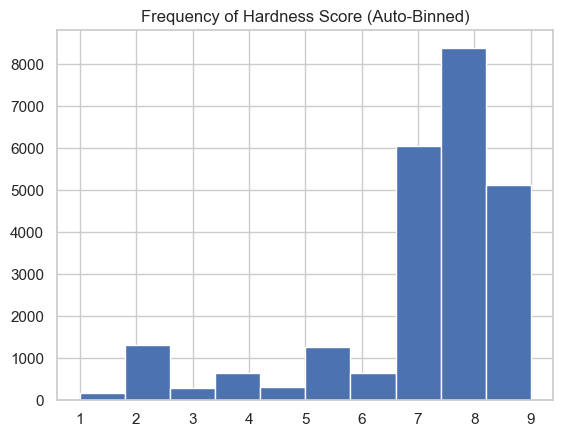

In [37]:
# Frequency of Hardness Scores

plt.hist(task_b_df['average_score'])
plt.title('Frequency of Hardness Score (Auto-Binned)')
plt.show()

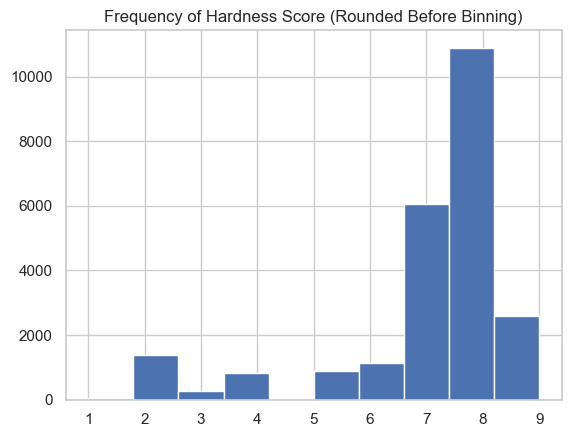

In [38]:
# Frequency of Hardness Scores Rounded Before Binning

plt.hist(task_b_df['average_score'].round().astype(int))
plt.title('Frequency of Hardness Score (Rounded Before Binning)')
plt.show()

In [39]:
task_b_df.head(1)

,question_id,prompt,score_value_1,score_value_2,score_value_3,e_0,e_1,e_2,e_3,e_4,...,e_247,e_248,e_249,e_250,e_251,e_252,e_253,e_254,e_255,average_score
0,58210e39b3fd4441a2bd4a518bb44c2d,What is the difference between OpenCL and CUDA?,9,8,9,-0.12,-0.12,0.04,0.02,0.09,...,-0.11,0.03,0.01,0.02,0.06,-0.16,-0.02,-0.04,-0.04,8.67


# 4a. Linear Regression Models (Feature Set 1)

*Features include embeddings only*

**MODEL 1**

In [40]:
# Feature Set 1: Just embeddings

# embeddings_matrix = task_b_df.drop(columns = ['question_id', 'cluster', 'score_value_1', 'score_value_2', 'score_value_3', 'average_score', 'total_hardness', 'prompt', 'cluster_score'])
embeddings_matrix = task_b_df.drop(columns = ['question_id', 'score_value_1', 'score_value_2', 'score_value_3', 'average_score', 'prompt'])
embeddings_matrix = embeddings_matrix.reset_index(drop=True)
embeddings_matrix.shape

(24106, 256)

In [41]:
# Feature Set 1 (Just embeddings)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings_matrix, task_b_df['average_score'], test_size=0.2, random_state=42)

# Model training
model1a = LinearRegression()
model1a.fit(X_train, y_train)

# Predict and evaluate
predictions1a = model1a.predict(X_test).round().astype(int)
mse1a = mean_squared_error(y_test, predictions1a)
print("Mean Squared Error:", mse1a)

Mean Squared Error: 2.0951887183741187


In [42]:
# 5 K-Fold Cross-Validation

X = embeddings_matrix
y = task_b_df['average_score']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores1a = cross_val_score(model1a, X, y, cv=kf, scoring='neg_mean_squared_error')#.round().astype(int)

# Since the scores are negative MSE, we might want to convert them to positive MSE
mse_scores1a = -scores1a

print("MSE scores for each fold:", mse_scores1a)
print("Average MSE:", mse_scores1a.mean())

MSE scores for each fold: [2.00565271 1.98727935 1.96684599 1.90532331 2.01105699]
Average MSE: 1.9752316690203844


# 4b. Linear Regression Models (Feature Set 2)
*Features include prompt quantifications, such as character count, word count, sentence count, words per sentence, unique words, and unique words to total words ratio*

**MODEL 2A**

In [43]:
# Feature Set 2a **

# Feature extraction
def extract_features2a(text):
    char_count = len(text)
    word_count = len(nltk.word_tokenize(text))
    char_word_ratio = char_count/word_count
    sent_count = len(nltk.sent_tokenize(text))
    words_per_sent = word_count / sent_count if sent_count > 0 else 0
    uniq_words = len(set(nltk.word_tokenize(text)))
    uniq_word_ratio = uniq_words / word_count if word_count > 0 else 0
    return [char_count, word_count, char_word_ratio, sent_count, words_per_sent, uniq_words]

# Applying feature extraction
features2a = merged_df['prompt'].apply(extract_features2a)
features2a_df = pd.DataFrame(features2a.tolist(), columns=['char_count', 'word_count', 'char_word_ratio', 'sent_count', 'words_per_sent', 'uniq_words'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features2a_df, merged_df['average_score'], test_size=0.2, random_state=42)

# Model training
model2a = LinearRegression()
model2a.fit(X_train, y_train)

# Predict and evaluate
predictions2a = model2a.predict(X_test).round().astype(int)
mse2a = mean_squared_error(y_test, predictions2a)
print("Mean Squared Error:", mse2a)


Mean Squared Error: 2.7575698314918027


**MODEL 2B**

In [44]:
# Feature extraction
def extract_features2b(text):
    char_count = len(text)
    word_count = len(nltk.word_tokenize(text))
    char_word_ratio = char_count/word_count
    sent_count = len(nltk.sent_tokenize(text))
    words_per_sent = word_count / sent_count if sent_count > 0 else 0
    uniq_words = len(set(nltk.word_tokenize(text)))
    uniq_word_ratio = uniq_words / word_count if word_count > 0 else 0
    fk_grade = textstat.flesch_kincaid_grade(text) # best
    gf_index = textstat.gunning_fog(text)
    return [char_count, word_count, char_word_ratio, sent_count, words_per_sent, uniq_words, uniq_word_ratio, fk_grade, gf_index]

# Applying feature extraction
features2b = merged_df['prompt'].apply(extract_features2b)
features2b_df = pd.DataFrame(features2b.tolist(), columns=['char_count', 'word_count', 'char_word_ratio', 'sent_count', 'words_per_sent', 'uniq_words', 'uniq_word_ratio', 'fk_grade', 'gf_index'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features2b_df, merged_df['average_score'], test_size=0.2, random_state=42)

# Model training
model2b = LinearRegression()
model2b.fit(X_train, y_train)

# Predict and evaluate
predictions2b = model2b.predict(X_test).round().astype(int)
mse2b = mean_squared_error(y_test, predictions2b)
print("Mean Squared Error:", mse2b)


Mean Squared Error: 2.6215573156024905


**MODEL 2C**

Replace fk_grade and gf_index grades with aggregated grade

* char_count = textstat.char_count(text)
* word_count = textstat.lexicon_count(text, removepunct=True)
* sent_count = textstat.sentence_count(text)
* words_per_sent = word_count / sent_count if sent_count > 0 else 0
* polysyll_count = textstat.polysyllabcount(text)
* uniq_words = len(set(word_tokenize(text)))
* uniq_word_ratio = uniq_words / word_count if word_count > 0 else 0
* grade

In [45]:
# Feature extraction
def extract_features2c(text):
    char_count = textstat.char_count(text)
    word_count = textstat.lexicon_count(text, removepunct=True)
    sent_count = textstat.sentence_count(text)
    words_per_sent = word_count / sent_count if sent_count > 0 else 0
    polysyll_count = textstat.polysyllabcount(text)
    uniq_words = len(set(word_tokenize(text)))
    uniq_word_ratio = uniq_words / word_count if word_count > 0 else 0
    grade = textstat.text_standard(text, float_output=True)
    return [char_count, word_count, sent_count, words_per_sent, polysyll_count, uniq_words, uniq_word_ratio, grade]#, readability, grade]

# Applying feature extraction
features2c = merged_df['prompt'].apply(extract_features2c)
features2c_df = pd.DataFrame(features2c.tolist(),
                            columns=['char_count', 'word_count', 'sent_count', 'words_per_sent',
                                     'polysyll_count', 'uniq_words', 'uniq_word_ratio',
                                     'complexity'])#, 'readability', 'grade'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features2c_df, merged_df['average_score'], test_size=0.2, random_state=42)

# Model training
model2c = LinearRegression()
model2c.fit(X_train, y_train)

# Predict and evaluate
predictions2c = model2c.predict(X_test).round().astype(int)
mse2c = mean_squared_error(y_test, predictions2c)
print("Mean Squared Error:", mse2c)


Mean Squared Error: 2.6700563866888305


**MODEL 2D**

Swap aggregated grade score with just Flesh-Kincaid and Gunning Fog grade-scoring indexes.

* char_count
* word_count
* sent_count
* words_per_sent
* polysyll_count
* uniq_words
* uniq_word_ratio
* fk_grade
* gf_index

In [46]:
# Feature extraction
def extract_features2d(text):
    char_count = textstat.char_count(text)
    word_count = textstat.lexicon_count(text, removepunct=True)
    sent_count = textstat.sentence_count(text)
    words_per_sent = word_count / sent_count if sent_count > 0 else 0
    polysyll_count = textstat.polysyllabcount(text)
    uniq_words = len(set(nltk.word_tokenize(text)))
    uniq_word_ratio = uniq_words / word_count if word_count > 0 else 0
    fk_grade = textstat.flesch_kincaid_grade(text)
    gf_index = textstat.gunning_fog(text)
    return [char_count, word_count, sent_count, words_per_sent, polysyll_count, uniq_words, uniq_word_ratio, fk_grade, gf_index]

# Applying feature extraction
features2d = merged_df['prompt'].apply(extract_features2d)
features2d_df = pd.DataFrame(features2d.tolist(), columns=['char_count', 'word_count', 'sent_count', 'words_per_sent', 'polysyll_count', 'uniq_words', 'uniq_word_ratio', 'fk_grade', 'gf_index'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features2d_df, merged_df['average_score'], test_size=0.2, random_state=42)

# Model training
model2d = LinearRegression()
model2d.fit(X_train, y_train)

# Predict and evaluate
predictions2d = model2d.predict(X_test).round().astype(int)
mse2d = mean_squared_error(y_test, predictions2d)
print("Mean Squared Error:", mse2d)

Mean Squared Error: 2.5922232000260754


In [47]:
# 5 K-Fold Cross-Validation

X = features2d_df
y = merged_df['average_score']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores2d = cross_val_score(model2d, X, y, cv=kf, scoring='neg_mean_squared_error')#.round().astype(int)

# Since the scores are negative MSE, we might want to convert them to positive MSE
mse_scores2d = -scores2d

print("MSE scores for each fold:", mse_scores2d)
print("Average MSE:", mse_scores2d.mean())

MSE scores for each fold: [2.50753503 2.35822615 2.64379417 2.61905511 2.4688373 ]
Average MSE: 2.519489551131757


**MODEL 2E**

Added in read time and complexity (ease score).

* char_count
* word_count
* sent_count
* words_per_sent
* polysyll_count
* uniq_words
* uniq_word_ratio
* fk_grade
* gf_index
* read_time
* complexity

In [48]:
# Feature extraction
def extract_features2e(text):
    char_count = textstat.char_count(text)
    word_count = textstat.lexicon_count(text, removepunct=True)
    sent_count = textstat.sentence_count(text)
    words_per_sent = word_count / sent_count if sent_count > 0 else 0
    polysyll_count = textstat.polysyllabcount(text)
    uniq_words = len(set(nltk.word_tokenize(text)))
    uniq_word_ratio = uniq_words / word_count if word_count > 0 else 0
    fk_grade = textstat.flesch_kincaid_grade(text)
    gf_index = textstat.gunning_fog(text)
    read_time = textstat.reading_time(text, ms_per_char=14.69)
    complexity = textstat.flesch_reading_ease(text)
    return [char_count, word_count, sent_count, words_per_sent, polysyll_count, uniq_words, uniq_word_ratio, fk_grade, gf_index, read_time, complexity]

# Applying feature extraction
features2e = merged_df['prompt'].apply(extract_features2e)
features2e_df = pd.DataFrame(features2e.tolist(), columns=['char_count', 'word_count', 'sent_count', 'words_per_sent',
                                                         'polysyll_count', 'uniq_words', 'uniq_word_ratio',
                                                         'fk_grade', 'gf_index', 'readability', 'complexity'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features2e_df, merged_df['average_score'], test_size=0.2, random_state=42)

# Model training
model2e = LinearRegression()
model2e.fit(X_train, y_train)

predictions2e = model2e.predict(X_test).round().astype(int)
mse2e = mean_squared_error(y_test, predictions2e)
print("Mean Squared Error:", mse2e)

Mean Squared Error: 2.596427756592028


In [49]:
# 5 K-Fold Cross-Validation

X = features2e_df
y = merged_df['average_score']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores2e = cross_val_score(model2e, X, y, cv=kf, scoring='neg_mean_squared_error')#.round().astype(int)

# Since the scores are negative MSE, we might want to convert them to positive MSE
mse_scores2e = -scores2e

print("MSE scores for each fold:", mse_scores2e)
print("Average MSE:", mse_scores2e.mean())

MSE scores for each fold: [2.49638352 2.32532891 2.6244671  2.600004   2.44309104]
Average MSE: 2.4978549123404905


## 4c. Linear Regression Models (Feature Set 3)
*Features include combinations of prompt quantifications and embeddings*

**MODEL 3A**

In [50]:
# Feature extraction
def extract_features3a(text):
    char_count = len(text)
    word_count = len(nltk.word_tokenize(text))
    char_word_ratio = char_count/word_count
    sent_count = len(nltk.sent_tokenize(text))
    words_per_sent = word_count / sent_count if sent_count > 0 else 0
    uniq_words = len(set(nltk.word_tokenize(text)))
    uniq_word_ratio = uniq_words / word_count if word_count > 0 else 0
    return [char_count, word_count, char_word_ratio, sent_count, words_per_sent, uniq_words]

# Applying feature extraction
features3a = task_b_df['prompt'].apply(extract_features3a)
features3a_df = pd.DataFrame(features3a.tolist(), columns=['char_count', 'word_count', 'char_word_ratio', 'sent_count', 'words_per_sent', 'uniq_words'])

# Reset the indices of both DataFrames if the indices do not matter
features3a_df = features3a_df.reset_index(drop=True)

# Add embeddings to features
features3a_df = pd.concat([features3a_df, embeddings_matrix], axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features3a_df, task_b_df['average_score'], test_size=0.2, random_state=42)


# Model training
model3a = LinearRegression()
model3a.fit(X_train, y_train)

# Predict and evaluate
predictions3a = model3a.predict(X_test).round().astype(int)
mse3a = mean_squared_error(y_test, predictions3a)
print("Mean Squared Error:", mse3a)


Mean Squared Error: 2.048665837135352


In [51]:
# NEW FEATURE SET 3a (prompt-text + embeddings)

# 5 K-Fold Cross-Validation

X = features3a_df
y = task_b_df['average_score']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores3a = cross_val_score(model3a, X, y, cv=kf, scoring='neg_mean_squared_error')#.round().astype(int)

# Since the scores are negative MSE, we might want to convert them to positive MSE
mse3a_scores = -scores3a

print("MSE scores for each fold:", mse3a_scores)
print("Average MSE:", mse3a_scores.mean())

MSE scores for each fold: [1.9632777  1.94913748 1.91231589 1.86523687 1.96537674]
Average MSE: 1.9310689356872133


**MODEL 3B**

In [52]:
# Feature extraction
def extract_features3b(text):
    char_count = textstat.char_count(text)
    word_count = textstat.lexicon_count(text, removepunct=True)
    sent_count = textstat.sentence_count(text) # not used in actual feature set
    words_per_sent = word_count / sent_count if sent_count > 0 else 0
    polysyll_count = textstat.polysyllabcount(text)
    uniq_words = len(set(nltk.word_tokenize(text)))
    uniq_word_ratio = uniq_words / word_count if word_count > 0 else 0
    fk_grade = textstat.flesch_kincaid_grade(text)
    gf_index = textstat.gunning_fog(text)
    return [char_count, word_count, sent_count, words_per_sent, polysyll_count, uniq_words, uniq_word_ratio, fk_grade, gf_index]

# Applying feature extraction
features3b = task_b_df['prompt'].apply(extract_features3b)
features3b_df = pd.DataFrame(features3b.tolist(), columns=['char_count', 'word_count', 'sent_count', 'words_per_sent', 'polysyll_count', 'uniq_words', 'uniq_word_ratio', 'fk_grade', 'gf_index'])

# Reset the indices of both DataFrames if the indices do not matter
features3b_df = features3b_df.reset_index(drop=True)
# Add embeddings
features3b_df = pd.concat([features3b_df, embeddings_matrix], axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features3b_df, task_b_df['average_score'], test_size=0.2, random_state=42)

# Model training
model3b = LinearRegression()
model3b.fit(X_train, y_train)

# Predict and evaluate
predictions3b = model3b.predict(X_test).round().astype(int)
mse3b = mean_squared_error(y_test, predictions3b)
print("Mean Squared Error:", mse3b)

Mean Squared Error: 1.9937093875293788


In [53]:
# Feature Set 3b (prompt-text + complexity + embeddings)

# 5 K-Fold Cross-Validation

X = features3b_df
y = task_b_df['average_score']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores3b = cross_val_score(model3b, X, y, cv=kf, scoring='neg_mean_squared_error')#.round().astype(int)

# Since the scores are negative MSE, we might want to convert them to positive MSE
mse3b_scores = -scores3b

print("MSE scores for each fold:", mse3b_scores)
print("Average MSE:", mse3b_scores.mean())

MSE scores for each fold: [1.92853675 1.91495744 1.87101823 1.82742731 1.94645616]
Average MSE: 1.8976791779644326


**MODEL 3C**

In [54]:
# Feature extraction
def extract_features3c(text):
    char_count = textstat.char_count(text)
    word_count = textstat.lexicon_count(text, removepunct=True)
    sent_count = textstat.sentence_count(text)
    words_per_sent = word_count / sent_count if sent_count > 0 else 0
    polysyll_count = textstat.polysyllabcount(text)
    uniq_words = len(set(nltk.word_tokenize(text)))
    uniq_word_ratio = uniq_words / word_count if word_count > 0 else 0
    fk_grade = textstat.flesch_kincaid_grade(text)
    gf_index = textstat.gunning_fog(text)
    read_time = textstat.reading_time(text, ms_per_char=14.69)
    complexity = textstat.flesch_reading_ease(text)
    return [char_count, word_count, sent_count, words_per_sent, polysyll_count, uniq_words, uniq_word_ratio, fk_grade, gf_index, read_time, complexity]

# Applying feature extraction
features3c = task_b_df['prompt'].apply(extract_features3c)
features3c_df = pd.DataFrame(features3c.tolist(), columns=['char_count', 'word_count', 'sent_count', 'words_per_sent',
                                                         'polysyll_count', 'uniq_words', 'uniq_word_ratio',
                                                         'fk_grade', 'gf_index', 'readability', 'complexity'])

# Reset the indices of both DataFrames if the indices do not matter
features3c_df = features3c_df.reset_index(drop=True)

# Add embeddings to feature set
features3c_df = pd.concat([features3c_df, embeddings_matrix], axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features3c_df, task_b_df['average_score'], test_size=0.2, random_state=42)

# Model training
model3c = LinearRegression()
model3c.fit(X_train, y_train)

# Predict and evaluate
predictions3c = model3c.predict(X_test).round().astype(int)
mse3c = mean_squared_error(y_test, predictions3c)
print("Mean Squared Error:", mse3c)


Mean Squared Error: 1.9789852066915528


In [55]:
# Feature Set 3c (prompt-text + complexity + embeddings)

# 5 K-Fold Cross-Validation

X = features3c_df
y = task_b_df['average_score']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores3c = cross_val_score(model3c, X, y, cv=kf, scoring='neg_mean_squared_error')#.round().astype(int)

# Since the scores are negative MSE, we might want to convert them to positive MSE
mse3c_scores = -scores3c

print("MSE scores for each fold:", mse3c_scores)
print("Average MSE:", mse3c_scores.mean())

MSE scores for each fold: [1.91947672 1.90859222 1.86790831 1.82232856 1.93217564]
Average MSE: 1.8900962904055025


# **5. Test on Validation Dataset**

## 5a. Import & Clean Validation Data

In [56]:
# Import validation set prompts

# Set URL of the validation prompts JSON
validation_prompts_url = "https://raw.githubusercontent.com/dychenster/nlp-chatarena/main/arena-validation-set-prompt-only.jsonl.gz"

# Read prompts JSON file into a DataFrame
validation_prompts = pd.read_json(validation_prompts_url, lines=True)

# Display the first row of the data
display(validation_prompts.head(1))
display(validation_prompts.shape)

,question_id,prompt,model_a,model_b
0,4f332ebd8cdc4ff2be74aa8828ff20d5,what do you think about the future of iran?,koala-13b,vicuna-13b


(3206, 4)

In [57]:
# Import validation set - topics

# Set URL of the validation topics JSON
validation_topics_url = "https://raw.githubusercontent.com/dychenster/nlp-chatarena/main/arena-validation-set-topic-modeling.jsonl.gz"

# Read topics JSON file into a DataFrame
validation_topics = pd.read_json(validation_topics_url, lines=True)

# Display the first row of the data
display(validation_topics.head(1))
display(validation_topics.shape)

,question_id,prompt,topic_modeling_1,topic_modeling_2,topic_modeling_3
0,4f332ebd8cdc4ff2be74aa8828ff20d5,what do you think about the future of iran?,Future Prediction,Future Prediction,Future Prediction


(3206, 5)

In [58]:
# Import validation set - embeddings

# Set URL of the validation embeddings JSON
validation_embeddings_url = "https://raw.githubusercontent.com/dychenster/nlp-chatarena/main/arena-validation-set-prompts-embeddings.npy"

# Use requests to get the file content
response_val = requests.get(validation_embeddings_url)

# Make sure the request was successful
if response_val.status_code == 200:
    # Load the content into a numpy array
    validation_content = BytesIO(response_val.content)
    validation_embeddings = np.load(validation_content)
    print("Embeddings loaded successfully into Colab.")
else:
    print(f"Failed to load the file. Status code: {response.status_code}")

Embeddings loaded successfully into Colab.


In [59]:
val_embeddings_df = pd.DataFrame(validation_embeddings, columns=[f'e_{i}' for i in range(256)])
print('The validation embeddings df has a shape of:', val_embeddings_df.shape) # (3206, 256)

validation_df = validation_prompts.merge(validation_topics, on="question_id")
print('The merged validation prompts and topics df has a shape of:', validation_df.shape) # (3208, 8)

# CHECK FOR DUPLICATES
print('The merged validation prompts and topics df has a shape of:', validation_prompts['question_id'].duplicated().sum())
print('The merged validation prompts and topics df has a shape of:', validation_topics['question_id'].duplicated().sum())

(3206, 256)

In [62]:
# CLEAN DUPLICATES

# Identify duplicate rows in the 'validation_prompts' DataFrame
duplicate_prompts = validation_prompts[validation_prompts.duplicated(subset='question_id', keep=False)]

# Identify duplicate rows in the 'validation_topics' DataFrame
duplicate_topics = validation_topics[validation_topics.duplicated(subset='question_id', keep=False)]

# Display the duplicate rows
print("Duplicate rows in validation_prompts based on question_id:")
print(duplicate_prompts)

print("\nDuplicate rows in validation_topics based on question_id:")
print(duplicate_topics)

# Add a column to mark the first two duplicates
validation_df['duplicate_count'] = validation_df.groupby('question_id').cumcount()

# Keep only the first two duplicates (i.e., where duplicate_count is 0 or 1)
validation_df_filtered = validation_df[validation_df['duplicate_count'] < 2].copy()

# Now drop the 'duplicate_count' column as it's no longer needed
validation_df_filtered.drop('duplicate_count', axis=1, inplace=True)

# Verify the result
print(validation_df_filtered.shape)

Duplicate rows in validation_prompts based on question_id:
                           question_id  \
2527  08003723f24740a6bdb547a10e70cad9   
2528  08003723f24740a6bdb547a10e70cad9   

                                                 prompt           model_a  \
2527  Wonderful. You must NEVER break character. You...  RWKV-4-Raven-14B   
2528  Wonderful. You must NEVER break character. You...  RWKV-4-Raven-14B   

                model_b  
2527  claude-instant-v1  
2528  claude-instant-v1  

Duplicate rows in validation_topics based on question_id:
                           question_id  \
2527  08003723f24740a6bdb547a10e70cad9   
2528  08003723f24740a6bdb547a10e70cad9   

                                                 prompt  \
2527  Wonderful. You must NEVER break character. You...   
2528  Wonderful. You must NEVER break character. You...   

             topic_modeling_1         topic_modeling_2    topic_modeling_3  
2527  Creativity, Imagination  imagination, creativity  Improv 

In [64]:
validation_df_filtered.drop(columns=["prompt_y"], inplace=True)
validation_df_filtered.rename(columns = {"prompt_x":"prompt"}, inplace=True)
validation_df_filtered.head()

,question_id,prompt,model_a,model_b,topic_modeling_1,topic_modeling_2,topic_modeling_3
0,4f332ebd8cdc4ff2be74aa8828ff20d5,what do you think about the future of iran?,koala-13b,vicuna-13b,Future Prediction,Future Prediction,Future Prediction
1,f2be6f13e5ed40e5b81443223996494c,Salut ! Tu es un méchant chatbot !,stablelm-tuned-alpha-7b,vicuna-13b,"Role-playing, Evaluation","Role-play, Evaluation","Creativity, Factual Accuracy"
2,5fafefb8a0c54243afb52d2892946cea,⚔️ Chatbot Arena ⚔️\nRules:\n Chat with two...,koala-13b,vicuna-13b,Chatbot Evaluation,Chatbot Evaluation,Chatbot Evaluation
3,7834f572267f40709ecebb273a2b346b,Guess the word that i have in my mind,chatglm-6b,stablelm-tuned-alpha-7b,Guessing Game,Word Guessing,Word Guessing
4,1ccc7e58290245c4bd5457fce45f8640,You are a peasant living in the village. But s...,vicuna-13b,koala-13b,"Problem-Solving, Creativity",Problem Solving,"Problem-solving, Creativity"


## 5b. Test Models Using Validation Set

In [ ]:
# Validation Distribution for Reference

# hardness_score
# 1     204
# 2     377
# 3      87
# 4      74
# 5     189
# 6     182
# 7    1087
# 8     913
# 9      93
# Name: count, dtype: int64


**TASK A PREDICTIONS**

In [67]:
# Create dataframe for Task A testing

task_a_val_df = validation_df_filtered.copy()

task_a_val_df["prompt_length"] = task_a_val_df["prompt"].str.len()
task_a_val_df["prompt_complexity"] = (task_a_val_df["prompt"]).apply(textstat.flesch_reading_ease)
task_a_val_df["prompt_grade"] = task_a_val_df["prompt"].apply(lambda x: textstat.text_standard(x, float_output=True))
task_a_val_df["prompt_time"] = task_a_val_df["prompt"].apply(lambda x: textstat.reading_time(x, ms_per_char=14.69))

# ADDED
# Add model win rate column
task_a_val_df["model_a_win_rate"] = task_a_val_df["model_a"].map(win_rates)
task_a_val_df["model_b_win_rate"] = task_a_val_df["model_b"].map(win_rates)

In [ ]:
# One-hot encode models
print(models_combined)

# Initialize the columns to zero
for model in models_combined:
    task_a_val_df[model] = 0

# Use logical OR to combine the one-hot encoding for both model_a and model_b
for model in models_combined:
    task_a_val_df[model] = ((task_a_df["model_a"] == model) | (task_a_df["model_b"] == model)).astype(int)

# Check OHE columns
task_a_val_df.columns

In [72]:
# Set test features
X_validation = task_a_val_df[features]

# Create predictions
y_validation_pred_encoded = model_task_a.predict(X_validation)

# Decode the predictions back to the original labels
winner_predictions = le.inverse_transform(y_validation_pred_encoded)

**TASK B PREDICTIONS**

In [66]:
# Create dataframe for Task B testing
task_b_val_df = validation_df_filtered.copy()

# Add embeddings
task_b_val_df.reset_index(drop=True, inplace=True)
val_embeddings_df.reset_index(drop=True, inplace=True)

task_b_val_df = pd.concat([task_b_val_df, val_embeddings_df], axis=1)
task_b_val_df.head(1)


,question_id,prompt,model_a,model_b,topic_modeling_1,topic_modeling_2,topic_modeling_3,e_0,e_1,e_2,...,e_246,e_247,e_248,e_249,e_250,e_251,e_252,e_253,e_254,e_255
0,4f332ebd8cdc4ff2be74aa8828ff20d5,what do you think about the future of iran?,koala-13b,vicuna-13b,Future Prediction,Future Prediction,Future Prediction,-0.06,-0.12,0.06,...,0.04,-0.04,0.04,0.00,-0.08,0.00,0.01,-0.02,-0.03,-0.06


**Examine variability in model performance**

In [73]:
# TEST MODEL 1A

# Predict and evaluate
val_predictions1a = model1a.predict(val_embeddings_df).astype(int)
# print("Predicted Hardness Score:", val_predictions1a[0])

Predicted Hardness Score: 6


In [74]:
# TEST MODEL 2D

# Applying feature extraction
val_features2d = task_b_val_df['prompt'].apply(extract_features2d)
val_features2d_df = pd.DataFrame(val_features2d.tolist(), columns=['char_count', 'word_count', 'sent_count', 'words_per_sent', 'polysyll_count', 'uniq_words', 'uniq_word_ratio', 'fk_grade', 'gf_index'])

# Reset the indices of both DataFrames if the indices do not matter
val_features2d_df = val_features2d_df.reset_index(drop=True)

# Predict and evaluate
val_predictions2d = model2d.predict(val_features2d_df).round().astype(int)
# print("Predicted Hardness Score:", val_predictions2d[0])

Predicted Hardness Score: 7


In [75]:
# TEST MODEL 2E

# Applying feature extraction
val_features2e = task_b_val_df['prompt'].apply(extract_features2e)
val_features2e_df = pd.DataFrame(val_features2e.tolist(), columns=['char_count', 'word_count', 'sent_count', 'words_per_sent',
                                                         'polysyll_count', 'uniq_words', 'uniq_word_ratio',
                                                         'fk_grade', 'gf_index', 'readability', 'complexity'])

# Reset the indices of both DataFrames if the indices do not matter
val_features2e_df = val_features2e_df.reset_index(drop=True)

# Predict and evaluate
val_predictions2e = model2e.predict(val_features2e_df).round().astype(int)
# print("Predicted Hardness Score:", val_predictions2e[0])

Predicted Hardness Score: 7


In [76]:
# TEST MODEL 3A

# Applying feature extraction
val_features3a = task_b_val_df['prompt'].apply(extract_features3a)
val_features3a_df = pd.DataFrame(val_features3a.tolist(), columns=['char_count', 'word_count', 'char_word_ratio', 'sent_count', 'words_per_sent', 'uniq_words'])

# Reset the indices of both DataFrames if the indices do not matter
val_features3a_df = val_features3a_df.reset_index(drop=True)

val_features3a_df = pd.concat([val_features3a_df, val_embeddings_df], axis=1)

# Predict and evaluate
val_predictions3a = model3a.predict(val_features3a_df).astype(int)
# print("Predicted Hardness Score:", val_predictions3a[0])

Predicted Hardness Score: 6


In [77]:
# TEST MODEL 3C

# Applying feature extraction
val_features3c = task_b_val_df['prompt'].apply(extract_features3c)
val_features3c_df = pd.DataFrame(val_features3c.tolist(), columns=['char_count', 'word_count', 'sent_count', 'words_per_sent',
                                                         'polysyll_count', 'uniq_words', 'uniq_word_ratio',
                                                         'fk_grade', 'gf_index', 'readability', 'complexity'])

# Reset the indices of both DataFrames if the indices do not matter
val_features3c_df = val_features3c_df.reset_index(drop=True)
# Add embeddings
val_features3c_df = pd.concat([val_features3c_df, val_embeddings_df], axis=1)

# Predict and evaluate
val_predictions3c = model3c.predict(val_features3c_df).round().astype(int)
# print("Predicted Hardness Score:", val_predictions3c[0])

Predicted Hardness Score: 7


# **6. Create CSV for Download**

In [79]:
from IPython.display import FileLink

In [80]:
# MODEL 1A PREDICTIONS

# Create DataFrame with specified columns
submission1a_df = pd.DataFrame({
    'question_id': validation_df_filtered['question_id'],
    'winner': winner_predictions, # list or array of winners
    'hardness_score': val_predictions1a},
    columns=['question_id', 'winner', 'hardness_score'])

# Save the DataFrame to a CSV file
submission1a_df.to_csv('submission1a.csv', index=False)

# Provide a link to download the file
display(FileLink('submission1a.csv'))

/Users/dianachen/Desktop/3039626046_3039579441/submission1a.csv

In [81]:
# MODEL 2D PREDICTIONS

# Create DataFrame with specified columns
submission2d_df = pd.DataFrame({
    'question_id': validation_df_filtered['question_id'],
    'winner': winner_predictions, # list or array of winners
    'hardness_score': val_predictions2d},
    columns=['question_id', 'winner', 'hardness_score'])

# Save the DataFrame to a CSV file
submission2d_df.to_csv('submission2d.csv', index=False)

# Provide a link to download the file
display(FileLink('submission2d.csv'))

/Users/dianachen/Desktop/3039626046_3039579441/submission2d.csv

In [82]:
# MODEL 2E PREDICTIONS

# Create DataFrame with specified columns
submission2e_df = pd.DataFrame({
    'question_id': validation_df_filtered['question_id'],
    'winner': winner_predictions, # list or array of winners
    'hardness_score': val_predictions2e},
    columns=['question_id', 'winner', 'hardness_score'])

# Save the DataFrame to a CSV file
submission2e_df.to_csv('submission2e.csv', index=False)

# Provide a link to download the file
display(FileLink('submission2e.csv'))

/Users/dianachen/Desktop/3039626046_3039579441/submission2e.csv

In [83]:
# MODEL 3A PREDICTIONS

# Create DataFrame with specified columns
submission3a_df = pd.DataFrame({
    'question_id': validation_df_filtered['question_id'],
    'winner': winner_predictions, # list or array of winners
    'hardness_score': val_predictions3a},
    columns=['question_id', 'winner', 'hardness_score'])

# Save the DataFrame to a CSV file
submission3a_df.to_csv('submission3a.csv', index=False)

# Provide a link to download the file
display(FileLink('submission3a.csv'))

/Users/dianachen/Desktop/3039626046_3039579441/submission3a.csv

In [84]:
# MODEL 3C PREDICTIONS

# Create DataFrame with specified columns
submission3c_df = pd.DataFrame({
    'question_id': validation_df_filtered['question_id'],
    'winner': winner_predictions, # list or array of winners
    'hardness_score': val_predictions3c},
    columns=['question_id', 'winner', 'hardness_score'])

# Save the DataFrame to a CSV file
submission3c_df.to_csv('submission3c.csv', index=False)

# Provide a link to download the file
display(FileLink('submission3c.csv'))

/Users/dianachen/Desktop/3039626046_3039579441/submission3c.csv

***References:***

[1] N. Mehrabi, F. Morstatter, N. Saxena, K. Lerman, and A. Galstyan, "A Survey on Bias and Fairness in Machine Learning," arXiv:1908.09635v2 [cs.LG], Sep. 2019. Available: https://arxiv.org/abs/1908.09635

[2] C.-H. Chiang and H.-y. Lee, "Can Large Language Models Be an Alternative to Human Evaluation?" in Proceedings of the 61st Annual Meeting of the Association for Computational Linguistics (ACL), Volume 1: Long Papers, pp. 15607–15631, July 2023. Available: https://www.aclweb.org/anthology/2023.acl-long.870

[3] van der Lee, C., Gatt, A., van Miltenburg, E., & Krahmer, E. (2021). Human evaluation of automatically generated text: Current trends and best practice guidelines. Computer Speech &amp; Language, 67, 101151. doi:10.1016/j.csl.2020.101151

[4] W.-L. Chiang, L. Zheng, Y. Sheng, A. N. Angelopoulos, T. Li, D. Li, B. Zhu, H. Zhang, M. I. Jordan, J. E. Gonzalez, and I. Stoica, "Chatbot Arena: An Open Platform for Evaluating LLMs by Human Preference," arXiv:2403.04132v1 [cs.AI], Mar. 2024. Available: https://arxiv.org/abs/2403.04132
